# Library Imports


In [1]:
! pip install scikit-plot==0.3.7


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  MinMaxScaler
import xarray as xr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from keras.models import load_model
from keras.layers.merge import concatenate

from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift, fftn, rfftn, ifftn
from sklearn.decomposition import PCA
import scipy.stats as st

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from numpy import argmax
from tensorflow.keras.utils import to_categorical
import warnings
import scikitplot as skplt
from operator import itemgetter
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report

plt.rcParams['figure.dpi'] = 100


# Data Extraction

In [3]:
! git clone https://github.com/boschresearch/CNC_Machining.git

Cloning into 'CNC_Machining'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (562/562), done.
remote: Total 1960 (delta 24), reused 580 (delta 19), pack-reused 1370
Receiving objects: 100% (1960/1960), 884.32 MiB | 55.45 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Checking out files: 100% (1710/1710), done.


# Data Loading

In [4]:
%cd /content/CNC_Machining
%pwd

/content/CNC_Machining


'/content/CNC_Machining'

In [5]:
import os
from utils import data_loader_utils

In [6]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]


labels = ["good","bad"]
path_to_dataset = "./data/"

In [7]:
X_data = []
y_data = []
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
            #concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

laoding files from ./data/M01/OP00/good... 
laoding files from ./data/M01/OP00/bad... 
laoding files from ./data/M02/OP00/good... 
laoding files from ./data/M02/OP00/bad... 
laoding files from ./data/M03/OP00/good... 
laoding files from ./data/M03/OP00/bad... 
laoding files from ./data/M01/OP01/good... 
laoding files from ./data/M01/OP01/bad... 
laoding files from ./data/M02/OP01/good... 
laoding files from ./data/M02/OP01/bad... 
laoding files from ./data/M03/OP01/good... 
laoding files from ./data/M03/OP01/bad... 
laoding files from ./data/M01/OP02/good... 
laoding files from ./data/M01/OP02/bad... 
laoding files from ./data/M02/OP02/good... 
laoding files from ./data/M02/OP02/bad... 
laoding files from ./data/M03/OP02/good... 
laoding files from ./data/M03/OP02/bad... 
laoding files from ./data/M01/OP03/good... 
laoding files from ./data/M01/OP03/bad... 
laoding files from ./data/M02/OP03/good... 
laoding files from ./data/M02/OP03/bad... 
laoding files from ./data/M03/OP03/good... 

In [8]:
# creating a single dataframe in order to perform EDA and data split
y_data = np.array(y_data)
eda_df = pd.DataFrame({'Labels':y_data})
eda_df['MACHINE'] = eda_df['Labels'].astype('string').str[:3]
eda_df['OPERATION PROCESS'] = eda_df['Labels'].astype('string').str[13:17]
eda_df['PROCESS HEALTH'] = ['NOTOK' if 'bad' in i else 'OK' for i in  eda_df['Labels']]
eda_df.head()

,Labels,MACHINE,OPERATION PROCESS,PROCESS HEALTH
0,M01_Aug_2019_OP00_000_good,M01,OP00,OK
1,M01_Aug_2019_OP00_001_good,M01,OP00,OK
2,M01_Aug_2019_OP00_003_good,M01,OP00,OK
3,M01_Aug_2019_OP00_004_good,M01,OP00,OK
4,M01_Aug_2019_OP00_005_good,M01,OP00,OK


# Data Preprocessing

## Data Padding

In [9]:
def data_padding(X_data):
  X_data_arr = np.array(X_data)
  print(f"Shape of Data before padding :  {len(X_data)}")
  m = max(map(len, X_data_arr))
  X_data_arr = np.array([np.pad(x, [(0, m - len(x)),(0,0)], 'constant') for x in X_data_arr])
  print(f"Shape of Data after padding : {X_data_arr.shape}")
  return X_data_arr

## Downsampling Function

In [10]:
def downsample_data(downsize_rate, X_data_arr):
  ds_all = pd.DataFrame()
  ds_all = ds_all.to_xarray()
  df_list = []
  print(f"Shape of Data before downsampling :  {len(X_data_arr)}")

  for i in X_data_arr:
    df = pd.DataFrame(i)
    df = df.groupby(np.arange(len(df))//downsize_rate).mean()
    df_list.append(df)

  X_resampled = np.array(df_list)
  print(f"Shape of Data after downsampling :  {len(X_resampled)}")
  return X_resampled

## Data Normalization Function

In [11]:
def normalize_data(data):
  ds_all = pd.DataFrame()
  ds_all = ds_all.to_xarray()
  df_list = []

  for i in data:
    df = pd.DataFrame(i)
    scaler = MinMaxScaler()
    scaler = scaler.partial_fit(df)
    df = scaler.transform(df)
    df_list.append(df)

  X_resampled = np.array(df_list)
  return X_resampled

# EDA

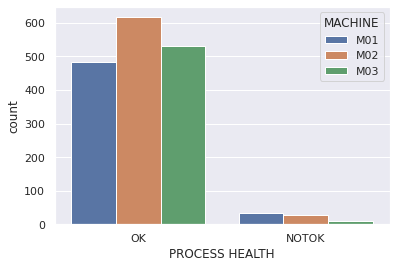

In [ ]:
sns.set(style="darkgrid")
sns.countplot(x='PROCESS HEALTH', data=eda_df, hue='MACHINE')

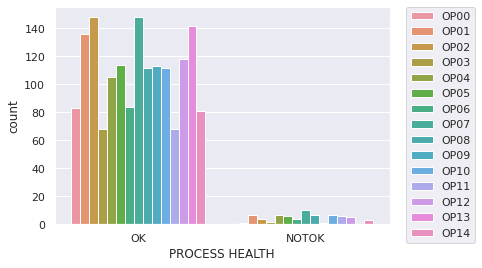

In [ ]:
sns.countplot(x='PROCESS HEALTH', data=eda_df, hue='OPERATION PROCESS')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
data = np.array(X_data)
all_mean_x = []
all_mean_y = []
all_mean_z = []
for i in X_data:
  all_mean_x.append(i[:,0].mean())
  all_mean_y.append(i[:,1].mean())
  all_mean_z.append(i[:,2].mean())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distribution of Vibrations Across X-Axis')

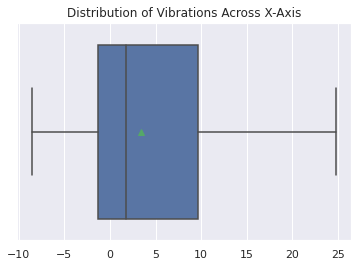

In [ ]:
sns.boxplot(x=all_mean_x,  showmeans=True)
plt.title('Distribution of Vibrations Across X-Axis')

Text(0.5, 1.0, 'Distribution of Vibrations Across Y-Axis')

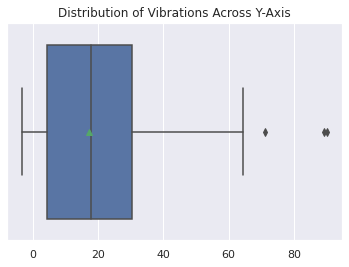

In [ ]:
sns.boxplot(x=all_mean_y,  showmeans=True)
plt.title('Distribution of Vibrations Across Y-Axis')

Text(0.5, 1.0, 'Distribution of Vibrations Across Z-Axis')

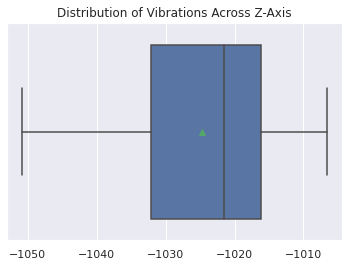

In [ ]:
sns.boxplot(x=all_mean_z,  showmeans=True)
plt.title('Distribution of Vibrations Across Z-Axis')

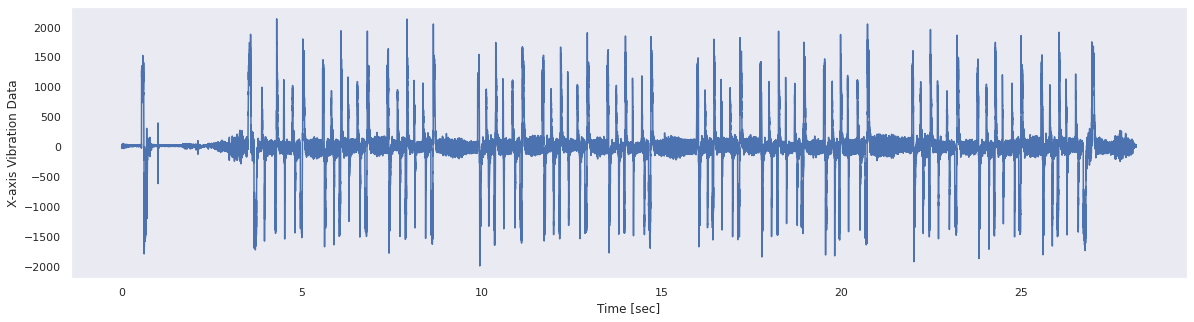

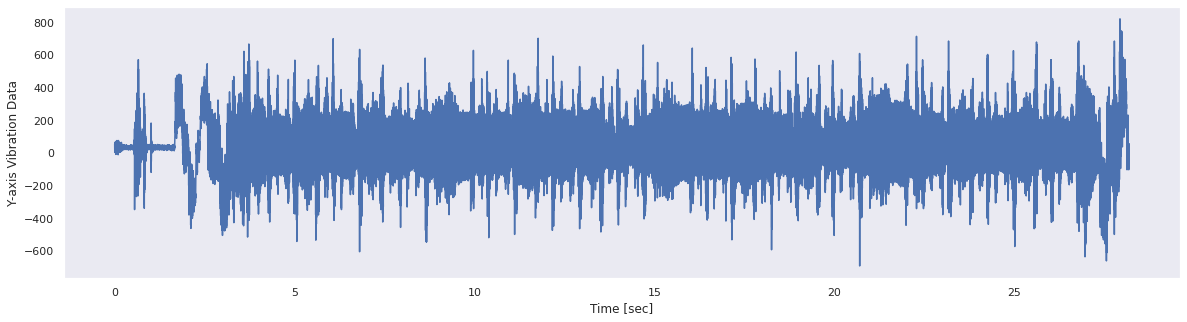

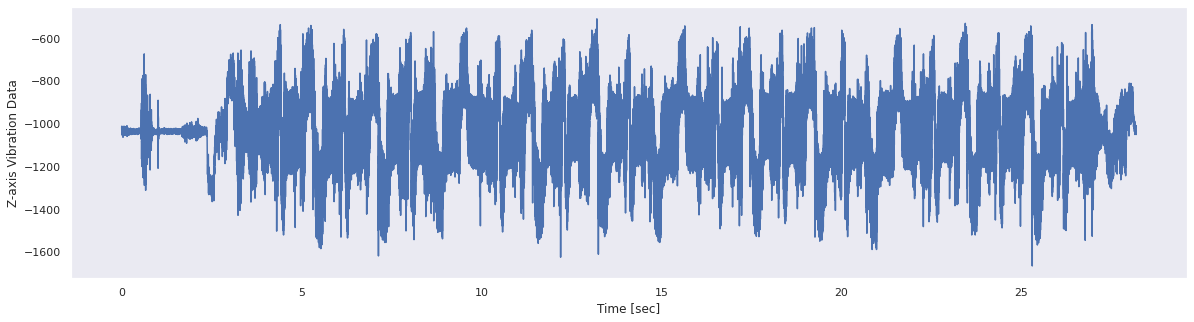

In [ ]:
file="./data/M01/OP01/good/M01_Feb_2019_OP01_003.h5"
sample = data_loader_utils.datafile_read(file)

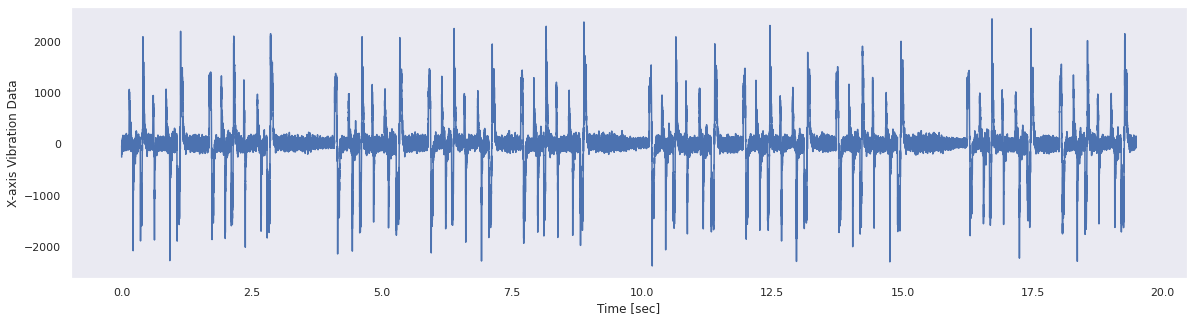

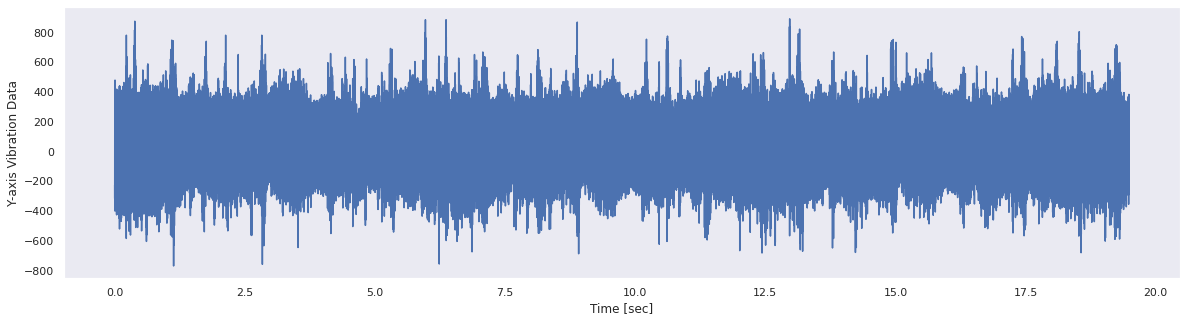

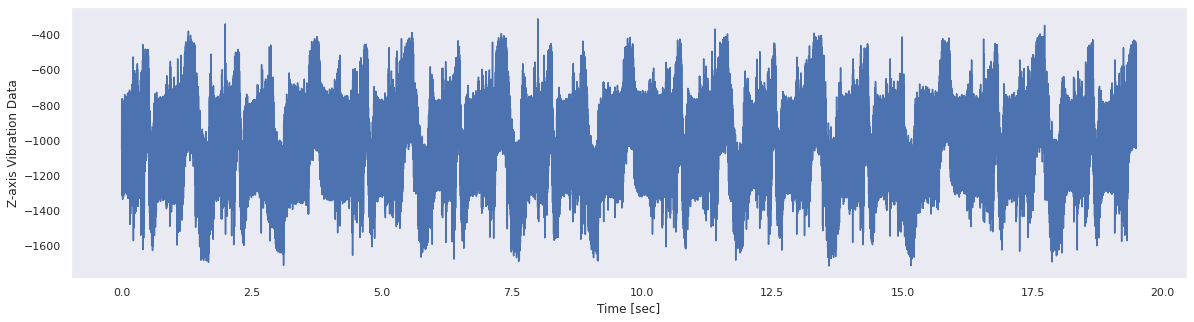

In [ ]:
file="./data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5"
sample = data_loader_utils.datafile_read(file)

# Util Functions

Functions that are used commonly between the models are defined in this section.

In [22]:
# Loss Function
def calculate_loss(loss, data_X, recon_X):
  if loss == 'mse':
      total_loss =  np.max(np.mean(np.square(recon_X - data_X),axis=-1), axis=-1)
  elif loss == 'mae':
      total_loss =  np.max(np.mean(np.absolute(recon_X - data_X),axis=-1), axis=-1)

  return total_loss

# Fast Fourier Transform Model

## Data Preprocessing

In [14]:
temp_1 = eda_df.loc[(eda_df['MACHINE'] == 'M01' )]
data_set_index = temp_1.index.values
gt_all = np.array([1 if 'bad' in i else 0 for i in y_data])

X_data_fft =  np.array(list(itemgetter(*data_set_index)(X_data)))
y_data_fft =  np.array(list(itemgetter(*data_set_index)(y_data)))
gt_data_fft = np.array(list(itemgetter(*data_set_index)(gt_all)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [15]:
DOWNSAMPLE_RATE = 2
X_data_arr = data_padding(X_data_fft)
X_resampled = downsample_data(DOWNSAMPLE_RATE, X_data_arr)
X_resampled = normalize_data(X_resampled)
print(f"Dataset shape after preprocessing {X_resampled.shape}")

Shape of Data before padding :  519
Shape of Data after padding : (519, 273408, 3)
Shape of Data before downsampling :  519
Shape of Data after downsampling :  519
Dataset shape after preprocessing (519, 136704, 3)


## Data Modelling

In [16]:
freq_list = list()

for d in X_resampled:
  all_3_fft = fftshift(fftn(d))
  freq_list.append(all_3_fft)

In [17]:
a = np.array(freq_list)
all_x = a[:,:,0].flatten()
all_y = a[:,:,1].flatten()
all_z = a[:,:,2].flatten()

In [18]:
weights = np.ones(shape=(X_resampled.shape[1],X_resampled.shape[2]))
x_min , x_max = st.norm.interval(alpha=0.85, loc=np.mean(all_x.real), scale=st.sem(all_x))
y_min , y_max = st.norm.interval(alpha=0.90, loc=np.mean(all_y.real), scale=st.sem(all_y))
z_min , z_max = st.norm.interval(alpha=0.70, loc=np.mean(all_z.real), scale=st.sem(all_z))

In [19]:
freq_list_filtered = list()

for f in freq_list:
  weights[:,0][f[:,0]<x_min] = 0
  weights[:,1][f[:,1]<y_min] = 0
  weights[:,2][f[:,2]<z_min] = 0

  weights[:,0][f[:,0]>x_max] = 0
  weights[:,1][f[:,1]>y_max] = 0
  weights[:,2][f[:,2]>z_max] = 0

  filtered = f * weights
  freq_list_filtered.append(filtered)


In [20]:
inv_freq_list = list()

for freq in freq_list_filtered:
  all_3_ifft = ifftshift(ifftn(d))
  inv_freq_list.append(all_3_fft)

In [23]:
total_loss = calculate_loss('mse', inv_freq_list, X_resampled)

# calculate threshold
threshold = np.mean(total_loss) + 0.25*np.std(total_loss)
threshold_ids = np.where(total_loss > threshold)

# predict anomaly based on threshold
pred_output = np.zeros(X_resampled.shape[0]).astype('int')
pred_output[threshold_ids] = 1

acc = accuracy_score(gt_data_fft[:], pred_output)
print('Stacked Test Accuracy: %.3f' % acc)


Stacked Test Accuracy: 0.615


## Model Evaluation

In [24]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# pred_outputs = pred_output
f1_score = f1_score(gt_data_fft, pred_output)

print('F-Measure: %.3f' % f1_score)

recall = recall_score(gt_data_fft, pred_output)
print('Recall: %.3f' % recall)

precision = precision_score(gt_data_fft, pred_output)
print('Precision: %.3f' % precision)

roc_auc = roc_auc_score(gt_data_fft, pred_output)
print('ROC-AUC: %.3f' % roc_auc)

print(classification_report(gt_data_fft, pred_output))

F-Measure: 0.187
Recall: 0.676
Precision: 0.108
ROC-AUC: 0.643
              precision    recall  f1-score   support

           0       0.96      0.61      0.75       485
           1       0.11      0.68      0.19        34

    accuracy                           0.61       519
   macro avg       0.54      0.64      0.47       519
weighted avg       0.91      0.61      0.71       519



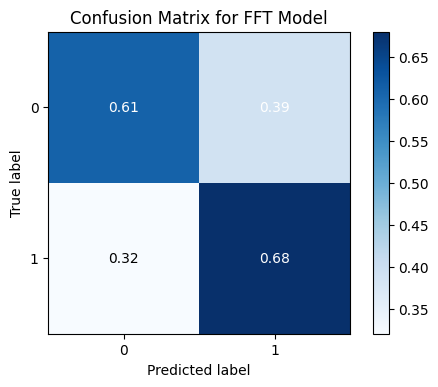

In [29]:
skplt.metrics.plot_confusion_matrix(gt_data_fft, pred_output, normalize=True, title = 'Confusion Matrix for FFT Model')

In [27]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(gt_data_fft, pred_output, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_data_fft.ravel(), pred_output.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

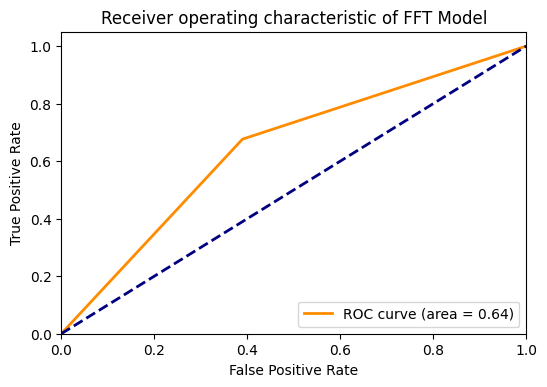

In [30]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of FFT Model")
plt.legend(loc="lower right")
plt.show()